# Logistic Regression

Create a logistic regression model with continuous and categorical features.

The purpose of this code is to show how PyMC may be used to create a generic logistic regression model.

We will start by

1. Defining the problem, then
2. create a test model that produces the softmax output (just to be sure the values are indeed constrained i.e. between 0 and 1), 
3. Create a specific model
4. Create a function to produce a generic model

In [1]:
import pymc as pm
import numpy as np
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import scipy as sp
import pytensor

# One of these settings will cause a Not Implemented error
# pytensor.config.optimizer = 'None'
# pytensor.config.exception_verbosity = 'high'

def one_hot_encode(series):
    series_encoded = np.zeros((len(series), len(np.unique(series))))
    for i, val in enumerate(np.unique(series)):
        series_encoded[series == val, i] = 1
    return series_encoded

def create_encoding_dict(series):
    edict = {}
    for i, val in enumerate(np.unique(series)):
        edict[val] = i
    return edict

def one_hot_encode_scalar(val, encoding_dict):
    inv_encoding_dict = {v: k for k, v in encoding_dict.items()}
    val_encoded = []
    is_last = True
    for i, key in enumerate(encoding_dict):
        if i < len(encoding_dict)-1:
            val_encoded.append(1 if val == inv_encoding_dict[i] else 0)
    return val_encoded

## Problem Definition

In this problem, let's say we want to predict `y`, that can be either 0, 1, or 2, from `x1`, a continuous variable, and `x2`, a categorical variable A, B, or C.

There will be 50 training data in this specific problem.

In [2]:
# Generate some synthetic data
np.random.seed(42)
x1 = np.linspace(0, 10, 50)
x2 = np.random.choice(["A", "B", "C"], size=50)
y = np.random.choice([0, 1, 2], size=50, p=[0.2, 0.3, 0.5])

# One-hot encode x2
x2_encoded = one_hot_encode(x2)

In [3]:
print("x1")
display(x1)
print("x2")
display(x2)
print("x2_encoded")
display(x2_encoded)
print("y")
display(y)

x1


array([ 0.        ,  0.20408163,  0.40816327,  0.6122449 ,  0.81632653,
        1.02040816,  1.2244898 ,  1.42857143,  1.63265306,  1.83673469,
        2.04081633,  2.24489796,  2.44897959,  2.65306122,  2.85714286,
        3.06122449,  3.26530612,  3.46938776,  3.67346939,  3.87755102,
        4.08163265,  4.28571429,  4.48979592,  4.69387755,  4.89795918,
        5.10204082,  5.30612245,  5.51020408,  5.71428571,  5.91836735,
        6.12244898,  6.32653061,  6.53061224,  6.73469388,  6.93877551,
        7.14285714,  7.34693878,  7.55102041,  7.75510204,  7.95918367,
        8.16326531,  8.36734694,  8.57142857,  8.7755102 ,  8.97959184,
        9.18367347,  9.3877551 ,  9.59183673,  9.79591837, 10.        ])

x2


array(['C', 'A', 'C', 'C', 'A', 'A', 'C', 'B', 'C', 'C', 'C', 'C', 'A',
       'C', 'B', 'A', 'B', 'B', 'B', 'B', 'A', 'A', 'B', 'B', 'A', 'A',
       'A', 'C', 'C', 'C', 'B', 'C', 'B', 'B', 'C', 'B', 'C', 'C', 'A',
       'C', 'A', 'C', 'C', 'A', 'A', 'C', 'B', 'A', 'B', 'B'], dtype='<U1')

x2_encoded


array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0

y


array([1, 0, 1, 1, 2, 2, 2, 0, 1, 0, 2, 1, 1, 2, 0, 2, 1, 1, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 0, 1, 1, 1, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 1, 0, 1, 2])

## Test Model - Softmax output

A test model to test the softmax output. Note that it does not use any data defined above.

In [4]:
x2_encoded[:, 0]

array([0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0.])

In [5]:
# Specify the model
with pm.Model() as testmodel:
    # Priors on the intercept and slopes
    intercept = pm.HalfNormal("intercept", sigma=1, shape=(3,))
    slope1 = pm.HalfNormal("slope1", sigma=1, shape=(3,))
    slope2a = pm.HalfNormal("slope2a",sigma=1, shape=(3,))
    slope2b = pm.HalfNormal("slope2b", sigma=1, shape=(3,))
    # Model the logit of the probability of y being 1, 2, or 3
    logit_p = intercept + slope1 * x1[:, None] \
              + slope2a * x2_encoded[:, 0][:, None] \
              + slope2b * x2_encoded[:, 1][:, None]
    softmax = pm.Deterministic("softmax", pm.math.softmax(logit_p))
    row_sums = pt.diag(1.0 / pt.sum(softmax, axis=1))
    norm_p = pt.dot(row_sums, softmax)
    probs = pm.Deterministic("probs", norm_p)

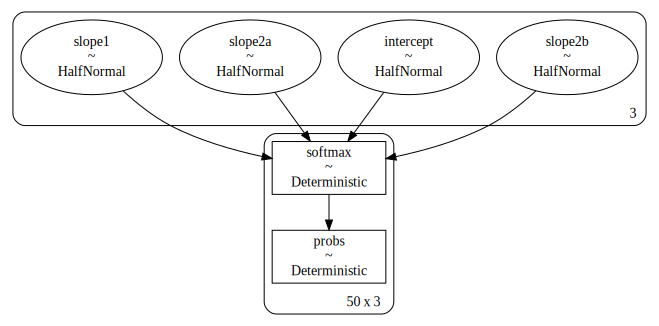

In [6]:
pm.model_to_graphviz(testmodel)

In [7]:
with testmodel:
    testmodel_trace = pm.sample(1, chains=1)

Only 1 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [intercept, slope1, slope2a, slope2b]


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 10 seconds.
/tmp/ipykernel_470669/3721708488.py:2: UserWarning: The number of samples is too small to check convergence reliably.
  testmodel_trace = pm.sample(1, chains=1)


In [8]:
testmodel_trace.posterior

<xarray.Dataset>
Dimensions:          (chain: 1, draw: 1, intercept_dim_0: 3, slope1_dim_0: 3,
                      slope2a_dim_0: 3, slope2b_dim_0: 3, softmax_dim_0: 50,
                      softmax_dim_1: 3, probs_dim_0: 50, probs_dim_1: 3)
Coordinates:
  * chain            (chain) int64 0
  * draw             (draw) int64 0
  * intercept_dim_0  (intercept_dim_0) int64 0 1 2
  * slope1_dim_0     (slope1_dim_0) int64 0 1 2
  * slope2a_dim_0    (slope2a_dim_0) int64 0 1 2
  * slope2b_dim_0    (slope2b_dim_0) int64 0 1 2
  * softmax_dim_0    (softmax_dim_0) int64 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * softmax_dim_1    (softmax_dim_1) int64 0 1 2
  * probs_dim_0      (probs_dim_0) int64 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
  * probs_dim_1      (probs_dim_1) int64 0 1 2
Data variables:
    intercept        (chain, draw, intercept_dim_0) float64 0.007805 ... 0.01447
    slope1           (chain, draw, slope1_dim_0) float64 0.1748 1.188 0.5291
    slope2a          (chain, draw, slope2a_dim_0) float64 0.6475 0.5447 2.295
    slope2b          (chain, draw, slope2b_dim_0) float64 0.297 2.272 0.4233
    softmax          (chain, draw, softmax_dim_0, softmax_dim_1) float64 2.12...
    probs            (chain, draw, probs_dim_0, probs_dim_1) float64 0.3072 ....
Attributes:
    created_at:                 2023-02-25T20:43:05.783597
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  5.0.2
    sampling_time:              10.201403379440308
    tuning_steps:               1000

Note that the values of softmax are constrained properly

## Specific Model

A model that specifically deals with the problem definition above.

In [9]:
# Specify the model
with pm.Model() as smodel:
    # Priors on the intercept and slopes
    intercept = pm.HalfNormal("intercept", sigma=1, shape=(3,))
    slope1 = pm.HalfNormal("slope1", sigma=1, shape=(3,))
    slope2a = pm.HalfNormal("slope2a",sigma=1, shape=(3,))
    slope2b = pm.HalfNormal("slope2b", sigma=1, shape=(3,))
    # Model the logit of the probability of y being 1, 2, or 3
    logit_p = intercept + slope1 * x1[:, None] \
              + slope2a * x2_encoded[:, 0][:, None] \
              + slope2b * x2_encoded[:, 1][:, None]
    softmax = pm.Deterministic("softmax", pm.math.softmax(logit_p))
    row_sums = pt.diag(1.0 / pt.sum(softmax, axis=1))
    norm_p = pt.dot(row_sums, softmax)
    probs = pm.Deterministic("probs", norm_p)
    
    category = pm.Categorical("y", p=probs, observed=y)

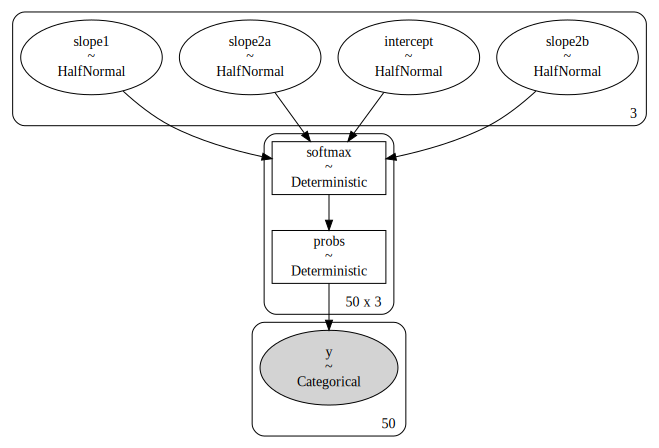

In [10]:
pm.model_to_graphviz(smodel)

In [11]:
# With softmax
with smodel:
    smodel_trace = pm.sample(1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope1, slope2a, slope2b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 122 seconds.


In [12]:
smodel_trace.posterior

<xarray.Dataset>
Dimensions:          (chain: 4, draw: 1000, intercept_dim_0: 3,
                      slope1_dim_0: 3, slope2a_dim_0: 3, slope2b_dim_0: 3,
                      softmax_dim_0: 50, softmax_dim_1: 3, probs_dim_0: 50,
                      probs_dim_1: 3)
Coordinates:
  * chain            (chain) int64 0 1 2 3
  * draw             (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * intercept_dim_0  (intercept_dim_0) int64 0 1 2
  * slope1_dim_0     (slope1_dim_0) int64 0 1 2
  * slope2a_dim_0    (slope2a_dim_0) int64 0 1 2
  * slope2b_dim_0    (slope2b_dim_0) int64 0 1 2
  * softmax_dim_0    (softmax_dim_0) int64 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * softmax_dim_1    (softmax_dim_1) int64 0 1 2
  * probs_dim_0      (probs_dim_0) int64 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
  * probs_dim_1      (probs_dim_1) int64 0 1 2
Data variables:
    intercept        (chain, draw, intercept_dim_0) float64 0.6805 ... 0.4192
    slope1           (chain, draw, slope1_dim_0) float64 0.2517 0.3515 ... 0.21
    slope2a          (chain, draw, slope2a_dim_0) float64 1.958 1.415 ... 0.596
    slope2b          (chain, draw, slope2b_dim_0) float64 2.439 1.681 ... 1.183
    softmax          (chain, draw, softmax_dim_0, softmax_dim_1) float64 0.00...
    probs            (chain, draw, probs_dim_0, probs_dim_1) float64 0.2577 ....
Attributes:
    created_at:                 2023-02-25T20:45:42.540805
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  5.0.2
    sampling_time:              122.42084407806396
    tuning_steps:               1000

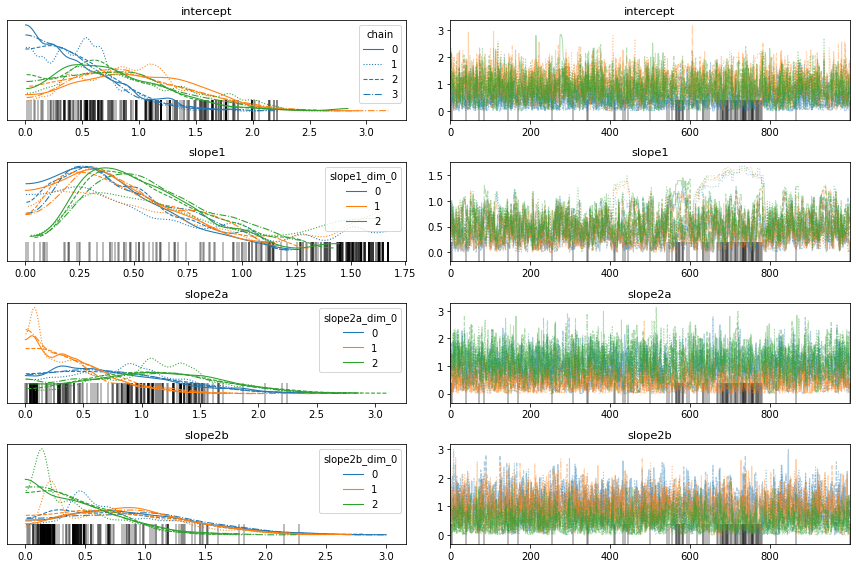

In [13]:
# Plot the posterior distributions
ax = az.plot_trace(smodel_trace, var_names=["intercept", "slope1", "slope2a", "slope2b"], combined=False, legend=True);

plt.tight_layout()

## Alternative Model - Without Softmax

The Softmax function was expensive, and we could argue it is not actually needed since the prior feature distributions were all using Half Normal, that ensure there would be no negative values.

Hence, we skip the Softmax part.

Notice the difference in time it took to sample and the fewer number of divergences (both are a sign of a better model)

In [14]:
x1

array([ 0.        ,  0.20408163,  0.40816327,  0.6122449 ,  0.81632653,
        1.02040816,  1.2244898 ,  1.42857143,  1.63265306,  1.83673469,
        2.04081633,  2.24489796,  2.44897959,  2.65306122,  2.85714286,
        3.06122449,  3.26530612,  3.46938776,  3.67346939,  3.87755102,
        4.08163265,  4.28571429,  4.48979592,  4.69387755,  4.89795918,
        5.10204082,  5.30612245,  5.51020408,  5.71428571,  5.91836735,
        6.12244898,  6.32653061,  6.53061224,  6.73469388,  6.93877551,
        7.14285714,  7.34693878,  7.55102041,  7.75510204,  7.95918367,
        8.16326531,  8.36734694,  8.57142857,  8.7755102 ,  8.97959184,
        9.18367347,  9.3877551 ,  9.59183673,  9.79591837, 10.        ])

In [15]:
# Specify the model
with pm.Model() as smodel_alt:
    # Priors on the intercept and slopes
    intercept = pm.HalfNormal("intercept", sigma=1, shape=(3,))
    slope1 = pm.HalfNormal("slope1", sigma=1, shape=(3,))
    slope2a = pm.HalfNormal("slope2a",sigma=1, shape=(3,))
    slope2b = pm.HalfNormal("slope2b", sigma=1, shape=(3,))
    # Model the logit of the probability of y being 1, 2, or 3
    logit_p = intercept + slope1 * x1[:, None] \
              + slope2a * x2_encoded[:, 0][:, None] \
              + slope2b * x2_encoded[:, 1][:, None]
    row_sums = pt.diag(1.0 / pt.sum(logit_p, axis=1))
    norm_p = pt.dot(row_sums, logit_p)
    probs = pm.Deterministic("probs", norm_p)
    
    category = pm.Categorical("y", p=probs, observed=y)

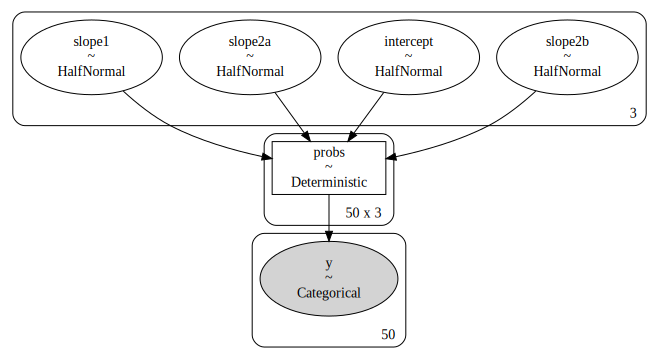

In [16]:
pm.model_to_graphviz(smodel_alt)

In [17]:
# Without softmax
with smodel_alt:
    smodel_alt_trace = pm.sample(1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope1, slope2a, slope2b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


In [18]:
smodel_alt_trace.posterior

<xarray.Dataset>
Dimensions:          (chain: 4, draw: 1000, intercept_dim_0: 3,
                      slope1_dim_0: 3, slope2a_dim_0: 3, slope2b_dim_0: 3,
                      probs_dim_0: 50, probs_dim_1: 3)
Coordinates:
  * chain            (chain) int64 0 1 2 3
  * draw             (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * intercept_dim_0  (intercept_dim_0) int64 0 1 2
  * slope1_dim_0     (slope1_dim_0) int64 0 1 2
  * slope2a_dim_0    (slope2a_dim_0) int64 0 1 2
  * slope2b_dim_0    (slope2b_dim_0) int64 0 1 2
  * probs_dim_0      (probs_dim_0) int64 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
  * probs_dim_1      (probs_dim_1) int64 0 1 2
Data variables:
    intercept        (chain, draw, intercept_dim_0) float64 0.2075 ... 1.326
    slope1           (chain, draw, slope1_dim_0) float64 0.3221 ... 1.522
    slope2a          (chain, draw, slope2a_dim_0) float64 0.5698 ... 1.323
    slope2b          (chain, draw, slope2b_dim_0) float64 0.7908 ... 0.6205
    probs            (chain, draw, probs_dim_0, probs_dim_1) float64 0.1168 ....
Attributes:
    created_at:                 2023-02-25T20:47:17.569313
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  5.0.2
    sampling_time:              45.925894021987915
    tuning_steps:               1000

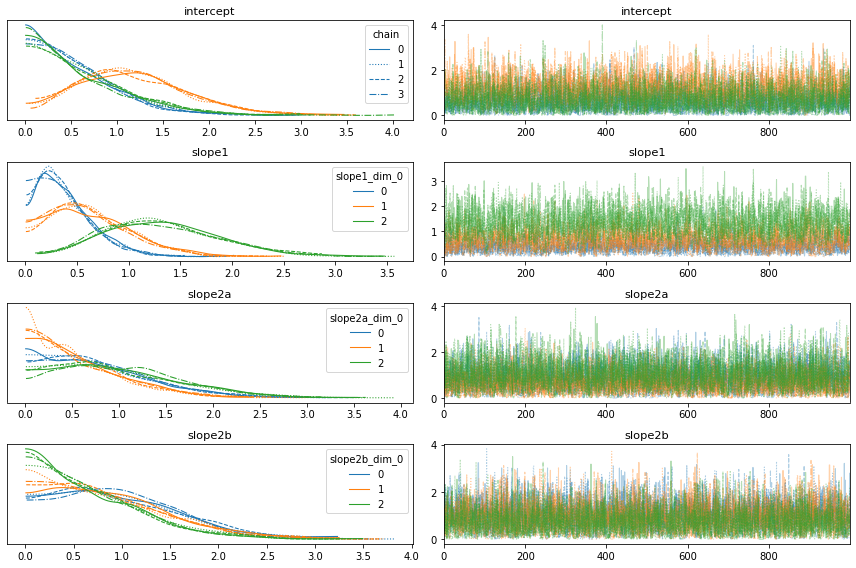

In [19]:
# Plot the posterior distributions
ax = az.plot_trace(smodel_alt_trace, var_names=["intercept", "slope1", "slope2a", "slope2b"], combined=False, legend=True);

plt.tight_layout()

We can see that the model is converged from the fact that there was no variation after some training.

## Using the model

Here is an example of how to use the model for prediction.

In [20]:
# Need to do this only once to create the encoding dictionary
x2_edict = create_encoding_dict(x2)
display(x2_edict)

{'A': 0, 'B': 1, 'C': 2}

In [21]:
m = smodel_alt_trace

x1_pred = 0.1
x2_pred = "B"
x2_pred_encoded = one_hot_encode_scalar(x2_pred, x2_edict)
intercept = np.mean(np.mean(np.array(m.posterior['intercept']), axis=0), axis=0)
slope1 = np.mean(np.mean(np.array(m.posterior['slope1']), axis=0), axis=0)
slope2a = np.mean(np.mean(np.array(m.posterior['slope2a']), axis=0), axis=0)
slope2b = np.mean(np.mean(np.array(m.posterior['slope2b']), axis=0), axis=0)

logit_p = intercept + slope1 * x1_pred \
          + slope2a * x2_pred_encoded[0] \
          + slope2b * x2_pred_encoded[1]

probs = logit_p / logit_p.sum()

display(probs)

array([0.3066583 , 0.41026797, 0.28307373])

In [22]:
x2_pred

'B'

In [23]:
m = smodel_alt_trace

x1_pred = np.array([0.1, 0.12])
x2_pred = np.array(["B", "A"])
x2_pred_encoded = one_hot_encode(x2_pred)
intercept = np.mean(np.mean(np.array(m.posterior['intercept']), axis=0), axis=0)
slope1 = np.mean(np.mean(np.array(m.posterior['slope1']), axis=0), axis=0)
slope2a = np.mean(np.mean(np.array(m.posterior['slope2a']), axis=0), axis=0)
slope2b = np.mean(np.mean(np.array(m.posterior['slope2b']), axis=0), axis=0)

logit_p = intercept + slope1 * x1_pred[:, None] \
          + slope2a * x2_pred_encoded[0][:, None] \
          + slope2b * x2_pred_encoded[1][:, None]

probs = logit_p / logit_p.sum(axis=1)[:, None]

display(probs)

array([[0.3066583 , 0.41026797, 0.28307373],
       [0.27915093, 0.3666802 , 0.35416887]])

In [24]:
y_dict = create_encoding_dict(y)
def display_probs(p, y_dict):
    if len(p.shape) == 1:
        p = p[:, None]
    print("Prediction results")
    for j, p_row in enumerate(p):
        print("prediction {}:".format(j))
        for i, k in enumerate(y_dict):
            print(i)
            y = y_dict[k]
            print("{}: {:.2%}".format(y, p_row[i]))
        print("")
display_probs(probs, y_dict)

Prediction results
prediction 0:
0
0: 30.67%
1
1: 41.03%
2
2: 28.31%

prediction 1:
0
0: 27.92%
1
1: 36.67%
2
2: 35.42%



## Generalized Model

In [25]:
list(range(x2_encoded.shape[1]))

[0, 1, 2]

In [26]:
def build_logistic_regression_model(inputs:dict, y):
    
    # Create the model:
    
    # Number of categories in y
    len_y = len(create_encoding_dict(y))
    
    with pm.Model() as model:
        # Priors on the intercept and slopes
        intercept = pm.HalfNormal("intercept", sigma=1, shape=(len_y,))
        slopes = {}
        
        # Model the logit of the probability
        logit_p = intercept
        for k in inputs:
            if inputs[k]['categorical']:
                if len(inputs[k]['values'].shape) == 1:
                    # Input contains values
                    encoded_input = one_hot_encode(inputs[k]['values'])
                else:
                    # Input contains encoded values
                    encoded_input = inputs[k]['values']
                for i in range(encoded_input.shape[1]-1):
                    slopes["{}{}".format(k, i)] = \
                        pm.HalfNormal("slope_{}{}".format(k, i), sigma=1, shape=(len_y,))
                    logit_p += slopes["{}{}".format(k, i)] * np.array(encoded_input[:, i])[:, None]
            else:
                slopes[k] = pm.HalfNormal("slope_{}".format(k), sigma=1, shape=(len_y,))
                logit_p += slopes[k] * np.array(inputs[k]['values'])[:, None]
                
        row_sums = pt.diag(1.0 / pt.sum(logit_p, axis=1))
        norm_p = pt.dot(row_sums, logit_p)
        probs = pm.Deterministic("probs", norm_p)

        category = pm.Categorical("y", p=probs, observed=y)
        
    # Create the predictor generator:
    def generate_predictor(model_trace, *kwargs):
        m = model_trace
        intercept = np.mean(np.mean(np.array(m.posterior['intercept']), axis=0), axis=0)
        logit_p = intercept
        input_params = []
        for idx, k in enumerate(inputs):
            input_params.append(pt.dmatrix(k))
            if inputs[k]['categorical']:
                if len(inputs[k]['values'].shape) == 1:
                    # Input contains values
                    encoded_input = one_hot_encode(inputs[k]['values'])
                else:
                    # Input contains encoded values
                    encoded_input = inputs[k]['values']
                for i in range(encoded_input.shape[1]-1):
                    slope = \
                        np.mean(np.mean(np.array(m.posterior['slope_{}{}'.format(k, i)]), axis=0), axis=0)
                    logit_p += slope * input_params[-1][:, i][:, None]
            else:
                slope = \
                    np.mean(np.mean(np.array(m.posterior['slope_{}'.format(k)]), axis=0), axis=0)
                logit_p += slope * input_params[-1]

        probs = logit_p / logit_p.sum(axis=1)[:, None]
        return pytensor.function(input_params, probs, on_unused_input='warn')
    
    
    return model, generate_predictor


model, generate_predictor = build_logistic_regression_model(
    {
        'x1': {'values': x1, 'categorical': False},
        'x2': {'values': x2, 'categorical': True}
    },
    y
)

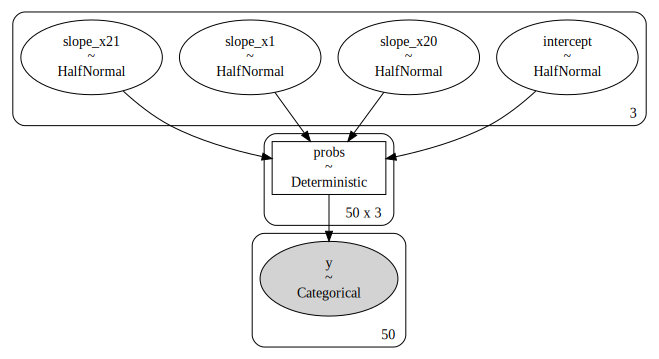

In [27]:
pm.model_to_graphviz(model)

In [28]:
with model:
    model_trace = pm.sample(1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope_x1, slope_x20, slope_x21]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


In [29]:
model_trace.posterior

<xarray.Dataset>
Dimensions:          (chain: 4, draw: 1000, intercept_dim_0: 3,
                      slope_x1_dim_0: 3, slope_x20_dim_0: 3,
                      slope_x21_dim_0: 3, probs_dim_0: 50, probs_dim_1: 3)
Coordinates:
  * chain            (chain) int64 0 1 2 3
  * draw             (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * intercept_dim_0  (intercept_dim_0) int64 0 1 2
  * slope_x1_dim_0   (slope_x1_dim_0) int64 0 1 2
  * slope_x20_dim_0  (slope_x20_dim_0) int64 0 1 2
  * slope_x21_dim_0  (slope_x21_dim_0) int64 0 1 2
  * probs_dim_0      (probs_dim_0) int64 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
  * probs_dim_1      (probs_dim_1) int64 0 1 2
Data variables:
    intercept        (chain, draw, intercept_dim_0) float64 1.55 ... 0.1625
    slope_x1         (chain, draw, slope_x1_dim_0) float64 0.01457 ... 1.411
    slope_x20        (chain, draw, slope_x20_dim_0) float64 0.5023 ... 0.9252
    slope_x21        (chain, draw, slope_x21_dim_0) float64 0.4555 ... 0.4741
    probs            (chain, draw, probs_dim_0, probs_dim_1) float64 0.5219 ....
Attributes:
    created_at:                 2023-02-25T20:48:59.238892
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  5.0.2
    sampling_time:              44.1694176197052
    tuning_steps:               1000

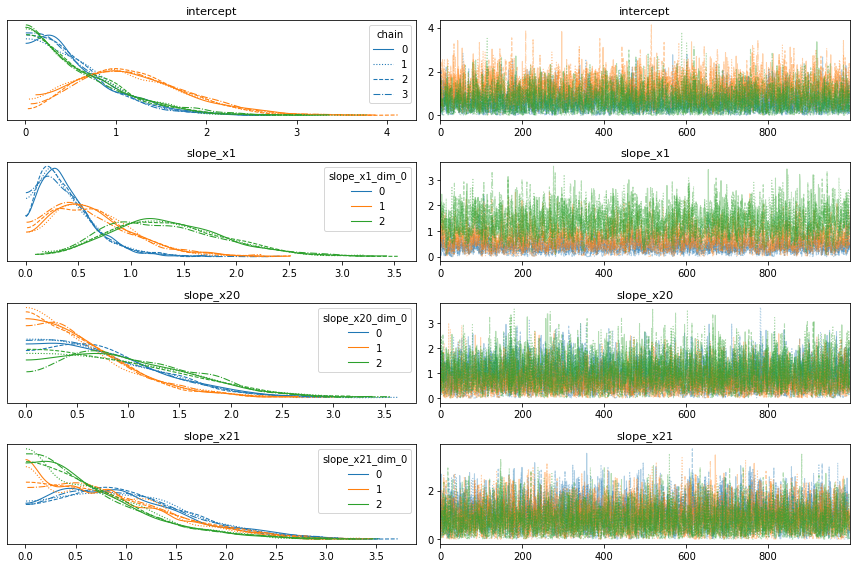

In [30]:
# Plot the posterior distributions
ax = az.plot_trace(model_trace, var_names=list(model_trace.posterior.data_vars), combined=False, legend=True);

plt.tight_layout()

In [31]:
x1_pred = np.array([[0.1], [0.12]])
# Or
x1_pred = np.array([0.1, 0.12])[:, None]
x2_pred = one_hot_encode(np.array(["B", "A"]))

predictor = generate_predictor(model_trace)
probs = predictor(x1_pred, x2_pred)

In [32]:
probs

array([[0.31123765, 0.40818163, 0.28058072],
       [0.27973857, 0.37019961, 0.35006181]])